In [1]:
# !pip install fasttext -U
# !pip install contractions -U
# !pip install pyspellchecker -U
# !pip install matplotlib -U
# !pip install seaborn -U
# !pip install nltk -U
# !pip install wordcloud -U
# !pip install scikit-learn -U
# !pip install scipy -U
# !pip install certifi
# !pip install pyenchant
# !pip install beautifulsoup4
# !pip install lxml
# !pip install tqdm

You should consider upgrading via the 'C:\Users\Gardo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# !wget -P resources/ 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
# !gdown "0Bz8a_Dbh9QhbZVhsUnRWRDhETzA" -O "resources/dataset.zip"

## Imports

In [38]:
import pandas as pd
import fasttext
from typing import List, Callable, Tuple, Any
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import os
from bs4 import BeautifulSoup
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import enchant
import concurrent.futures
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils.extmath import randomized_svd
from spellchecker import SpellChecker
import nltk
from wordcloud import WordCloud
import re
import numpy as np
from numpy import diag
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Constants

In [29]:
RESOURCES_FOLDER = 'resources'
FAST_TEXT_MODEL = f'{RESOURCES_FOLDER}/lid.176.bin'
DATASET_PATH = f'{RESOURCES_FOLDER}/dataset.csv'
RANDOM_STATE = 1234
PREPROCESSED_FOLDER = f'{RESOURCES_FOLDER}/preprocessed'
CONDENSED_DATASET = f'{PREPROCESSED_FOLDER}/condensed_dataset.csv'
ONLY_ENGLISH = f'{PREPROCESSED_FOLDER}/only_english_dataset.csv'
PREPROCESSED_DATASET = f'{RESOURCES_FOLDER}/preprocessed_dataset.csv'

negatives = {
    "no",
    "not",
    "never",
    "neither",
    "nor",
    "none",
    "nobody",
    "nowhere",
    "nothing",
    "hardly",
    "barely",
    "scarcely",
    "few",
    "little",
    "less",
    "without",
    "unless",
    "except",
    "but",
    "although",
    "though",
    "yet",
}
modal_verbs = {
    "cannot",
    "can't",
    "won't",
    "don't",
    "doesn't",
    "didn't",
    "shouldn't",
    "couldn't",
    "wouldn't",
    "mustn't",
    "needn't",
    "mightn't",
    "mayn't",
    "oughtn't",
    "daren't",
    "is",
    "are",
    "was",
    "were",
    "am",
    "have",
    "has",
    "had",
    "do",
    "does",
    "did",
    "can",
    "will",
    "would",
    "shall",
    "should",
    "may",
    "might",
    "must",
    "could",
    "ought",
    "dare",
    "need",
}
uncertainty_questioning = {
    "maybe",
    "perhaps",
    "possibly",
    "conceivably",
    "likely",
    "uncertain",
    "doubtful",
    "dubious",
    "question",
    "query",
}

## Utility functions

- `sample balanced`: takes at most `max_samples_per_class` from each class specified in `groupby_column`
- `compute_languages`: compute language for specified Series. It creates a new Series with `__label__[language]` for each text in the original Series

### DataFrame processing

In [52]:
def sample_balanced(dataframe: pd.DataFrame, 
                    max_samples_per_class: int = 20_000, 
                    groupby_column: str = 'stars', 
                    random_state: int = RANDOM_STATE):
  return dataframe.groupby(groupby_column)\
  .apply(lambda x: x.sample(max_samples_per_class, random_state=random_state))\
  .reset_index(drop=True)

def compute_languages(texts: pd.Series):
  model = fasttext.load_model(FAST_TEXT_MODEL)
  return texts.apply(lambda x: model.predict(x)[0][0])

def set_columns(columns: List[str]):
  def _set_columns(dataframe: pd.DataFrame):
    dataframe.columns = columns
    return dataframe
  return _set_columns

def drop_na():
  def _drop_na(dataframe: pd.DataFrame):
    return dataframe.dropna()
  return _drop_na

def remove_not_modal_languages(extracted_languages: pd.Series):
  def _remove_languages(dataframe: pd.DataFrame):
    modal_language = extracted_languages.value_counts().index[0]
    return dataframe[extracted_languages == modal_language].reset_index(drop=True)
  return _remove_languages

def compute_and_remove_not_modal_languages(text_column: str = 'text'):
  def _compute_and_remove(dataframe: pd.DataFrame):
    computed_languages = compute_languages(dataframe[text_column])
    return remove_not_modal_languages(computed_languages)(dataframe)
  return _compute_and_remove

def apply_preprocess(preprocess_functions: List[Callable]):
  def _apply_preprocess(dataframe: pd.DataFrame):
    for function in preprocess_functions:
      dataframe = function(dataframe)
    return dataframe
  return _apply_preprocess

def save_csv(dataframe: pd.DataFrame, path:str, verbose:bool = True):
    dataframe.to_csv(path, index=False)
    if verbose:
        print('file saved')
        
def load_csv(path:str):
    return pd.read_csv(path)

def apply(series: pd.Series, mapping_function: Callable[[Any], Any]) -> List[Any]:
    return [mapping_function(value) for value in series.values]    

### Text processing

In [53]:
def to_lower(text: str):
  return text.lower()

def expand_contraction(word: str):
  return contractions.fix(word)

def is_stopword(language: str = 'english'):
  stopwords_set = cleared_stopwords(language)
  def _is_stopword(word: str):
    return word in stopwords_set
  return _is_stopword

def cleared_stopwords(language: str = 'english'):
    return set(stopwords.words(language)) - uncertainty_questioning - negatives - modal_verbs

def is_punctuation(word: str):
  return word in string.punctuation

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def correct_word(language: str = 'eng'):
  checker = SpellChecker(language)
  def _correct_words(word: str):
    return checker.correction(word)
  return _correct_words

def is_in_dictionary(language: str = "en_US"):
    dictionary = enchant.Dict(language)
    def _is_in_dictionary(word: str):
        return dictionary.check(word)
    return _is_in_dictionary

def tokenize(text: str):
  return word_tokenize(text)

def split(text: str):
    return text.split()

def remove_lxml():
    def _remove_lxml(text):
        return BeautifulSoup(text, 'lxml').get_text().strip()
    return _remove_lxml

def expand():
    def _expand(text):
        return contractions.fix(text)
    return _expand
    
def map_text(mapping_function):
    def _map_text(text):
        return mapping_function(text)
    return _map_text

def remove_links():
    def _remove_links(text):
        return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', "", text)
    return _remove_links
  
def remove_mails():
    def _remove_mails(text):
        return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', "", text)
    return _remove_mails      


def generic_regex(pattern, repl):
    def _generic_regex(text):
        return re.sub(pattern, repl, text)
    return _generic_regex

def stopwords_list(language='english'):
    return stopwords.words(language)

def preprocess():
    stopword_regex = r'\b(' + r'|'.join(stopwords_list()) + r')\b\s*'
    remove_lxml_fn = remove_lxml()
    def _preprocess(text):
        functions = [
            map_text(lambda x: x.lower()),
            remove_links(), # remove links
            remove_mails(), # remove mails
            remove_lxml_fn,
            #expand(),
            generic_regex('[^a-z]', ' '), # remove all non chars
            generic_regex(r'\s+[a-z]\s+', ' '), # remove all isolated characters
            generic_regex(stopword_regex, ''), # remove stopwords
            generic_regex(r'\s+', ' ') # remove extra white spaces
        ]
        for function in functions:
            text = function(text)   
        return text
    return _preprocess

def normalise(text):
    return re.compile(r"[^a-z0-1\s]").sub(r" ",re.compile(r"['\W']").sub(r" ",text.lower()))
  

### LSA Manipulation

In [8]:
def tf_idf(corpus: pd.Series) -> Tuple[np.matrix, np.array]:
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    # l2 norm is already applied by TfidfVectorizer
    return tfidf_matrix, tfidf_vectorizer.get_feature_names_out() 

def normalize_by_rows(values: np.array):
    return np.linalg.norm(values, axis=1)

def sparsity(sparse_matrix: csr_matrix):
    print(sparse_matrix.shape)
    total_elements = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    zero_elements = total_elements - sparse_matrix.count_nonzero()
    return zero_elements / total_elements    

### Visualization

In [42]:
def plot_distribution(distribution: pd.Series, 
                      xlabel:str = '', 
                      ylabel:str = '', 
                      title: str = '', 
                      invert_axis: bool = False):
  plt.figure(figsize=(8, 4))  # Optional: Adjust the figure size
  data = distribution.to_list() if not invert_axis else list(distribution.index)
  index = list(distribution.index) if not invert_axis else distribution.to_list()
  sns.barplot(x=data, y=index)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  
def plot_singular_values(singular_values: List[float]):
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(singular_values) + 1), y=singular_values, marker='o')
    plt.title('Singular Values')    
    plt.show()

def word_cloud(text: str, title: str = ""):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')  # Hide the axis
  plt.show()

## Dataset analysis and manipulation

### Data loading

Dataset is a csv divided in 3 columns:
- *stars*: is the number of stars given by users in the review
- *title*: is the title of the review
- *text*: is the text of the review

Loading of dataframe, the original csv doesn't have column names, so I add it.

In [43]:
dataset = pd.read_csv(DATASET_PATH, header=None)
dataset = set_columns(['stars', 'title', 'text'])(dataset)
dataset.head()

,stars,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


Show the number of elements for each class

In [44]:
dataset['stars'].value_counts()

stars
3    600000
5    600000
4    600000
1    600000
2    600000
Name: count, dtype: int64

### Nan drop

As we can see classes are balanced. Now check the number of NaNs

In [45]:
dataset.isna().sum()

stars      0
title    188
text       0
dtype: int64

Remove empty cells

In [46]:
dataset = drop_na()(dataset)
dataset.isna().sum()

stars    0
title    0
text     0
dtype: int64

### Merge title and text columns

Now merge `title` and `text` together removing the column `title`

In [47]:
dataset['text'] = dataset['title'] + " " + dataset['text']
del dataset['title']
dataset.head()

,stars,text
0,3,more like funchuck Gave this to my dad for a g...
1,5,Inspiring I hope a lot of people hear this cd....
2,5,The best soundtrack ever to anything. I'm read...
3,4,Chrono Cross OST The music of Yasunori Misuda ...
4,5,Too good to be true Probably the greatest soun...


### Stars to sentiment

The 5 stars problems is too wide, and some reviews could be not accurate for the specified star. It's better to analyze the overall sentiment condensing the stars in 3 buckets: 
- 1-2 becomes 0 = "bad"
- 3 becomes 1 = "indifferent"
- 4-5 becomes 2 = "good"

In [48]:
dataset['sentiment'] = dataset['stars'].replace({1:0, 2:0, 3:1, 4:2, 5:2})
del dataset['stars']
dataset.head()

,text,sentiment
0,more like funchuck Gave this to my dad for a g...,1
1,Inspiring I hope a lot of people hear this cd....,2
2,The best soundtrack ever to anything. I'm read...,2
3,Chrono Cross OST The music of Yasunori Misuda ...,2
4,Too good to be true Probably the greatest soun...,2


### Language cleaning

Author specifies that there are some reviews not in English. Let's use fasttext, developed by Facebook, to find the languages.

In [49]:
languages_text = compute_languages(dataset['text'])

Now check the distributions of languages

In [50]:
languages_text.value_counts()

text
__label__en     2991674
__label__es        5381
__label__ja        1512
__label__fr         556
__label__pt         258
__label__de         135
__label__it         126
__label__nl          22
__label__pl          20
__label__zh          14
__label__sr          13
__label__sv          11
__label__id           9
__label__tr           9
__label__ca           6
__label__la           5
__label__tl           4
__label__cy           4
__label__oc           4
__label__da           4
__label__ms           3
__label__hu           3
__label__sh           3
__label__sl           3
__label__el           2
__label__kn           2
__label__hr           2
__label__no           2
__label__ia           2
__label__fi           2
__label__ba           2
__label__ro           2
__label__eo           2
__label__cs           1
__label__lt           1
__label__is           1
__label__vec          1
__label__uk           1
__label__ru           1
__label__sc           1
__label__mk           1
__label__ml

There are instances not in English. Remove all not English reviews in title and text

In [51]:
dataset = remove_not_modal_languages(languages_text)(dataset)
save_csv(dataset, ONLY_ENGLISH)

file saved


## Text preprocessing

Now we preprocessed the dataframe to be manipulated and used in deep learning methods and with LSA. The operations that are performed sequentially are:
- text to lower case
- tokenization, 
- expansion of contractions, 
- word correction, 
- stop word removal 
- punctuation removal

In [54]:
#processing_fn = preprocess_text()
processing_fn = normalise
dataset['text'] = apply(dataset['text'], processing_fn)
save_csv(dataset, PREPROCESSED_DATASET)

KeyboardInterrupt: 

In [21]:
# grouped = train.groupby('stars')['text'].apply(lambda x: ' '.join(x)).reset_index()
# for star_rating, reviews in zip(grouped['stars'], grouped['text']):
#   word_cloud(reviews, f'Word cloud for {star_rating} stars')
  
# Concatenate the aggregated reviews into a single string

In [22]:
tfidf_sparse, words = tf_idf(dataset['text'])
print(f'{len(words)} words founded')
U, Sigma, V_T = randomized_svd(tfidf_sparse, n_components=100)

29214 words founded


In [23]:
print(f'U shape: {U.shape}')
print(U)

U shape: (25000, 100)
[[ 0.00483947 -0.00224517 -0.00224802 ... -0.00355663  0.00208979
  -0.00295472]
 [ 0.00645314  0.00402697 -0.00307771 ...  0.0003605   0.00533838
   0.00393669]
 [ 0.00790449 -0.00868736  0.02630125 ...  0.00736537 -0.00167199
   0.00849665]
 ...
 [ 0.00896851  0.00605536 -0.00549983 ... -0.00437298 -0.00439759
   0.00461399]
 [ 0.00554946 -0.00374393 -0.0032348  ... -0.0027632  -0.00427257
   0.00243234]
 [ 0.00542744 -0.00232934 -0.00101735 ... -0.00134889 -0.00313988
  -0.00109029]]


In [24]:
print(f'Sigma {Sigma.shape}')
print(Sigma)

Sigma (100,)
[25.15441013 12.49709176 11.08254914 10.2165961   9.39571703  8.50463435
  8.21783332  8.00222576  7.79140857  7.48003869  7.42897216  7.17088674
  6.9820195   6.75166365  6.70757616  6.6297646   6.49803968  6.43943683
  6.36247142  6.2820453   6.23962106  6.15326587  6.11053163  6.0565609
  5.98502847  5.96847194  5.92493738  5.90373338  5.8733777   5.84305529
  5.75036579  5.73570654  5.69774081  5.65122941  5.59887099  5.58598316
  5.5802069   5.53994023  5.53339627  5.49972116  5.42758872  5.40715221
  5.39919838  5.35948814  5.33317855  5.32123979  5.30399126  5.28530604
  5.25542783  5.23952056  5.22168325  5.18269006  5.15887751  5.12329954
  5.1220959   5.10540045  5.09221685  5.0719251   5.05072771  5.03218755
  5.02204829  5.01169184  4.98995308  4.98011913  4.96779408  4.94295851
  4.92179142  4.91352291  4.89014161  4.8749606   4.85544896  4.85084366
  4.83622992  4.81926063  4.80132199  4.79209124  4.76340601  4.75569079
  4.73390514  4.71414961  4.70692585  4

In [25]:
print(f'V transposed {V_T.shape}')
print(V_T)

V transposed (100, 29214)
[[ 7.63322471e-04  7.79851237e-05  5.33464160e-04 ...  7.40224320e-05
   3.82131684e-05  1.71460049e-04]
 [-8.35319169e-04 -1.56850372e-04 -6.40609467e-04 ... -1.11020308e-04
  -5.00827933e-05 -9.85100900e-05]
 [-9.52604565e-04 -1.62088080e-04 -6.01643818e-04 ...  7.67927909e-05
  -9.52717678e-05 -1.50747973e-04]
 ...
 [-1.10138443e-03 -1.13861911e-05  6.56006369e-04 ...  1.14587078e-04
   1.20372015e-04  1.22283614e-05]
 [-1.39949280e-03 -1.49378266e-04  6.93802290e-04 ...  7.12208789e-05
  -2.52523754e-04 -4.52393059e-04]
 [-7.99117794e-04  3.17307963e-04  1.11967241e-04 ... -4.51585175e-04
  -2.82065268e-05 -6.81271762e-04]]


[25.15441013 12.49709176 11.08254914 10.2165961   9.39571703  8.50463435
  8.21783332  8.00222576  7.79140857  7.48003869]


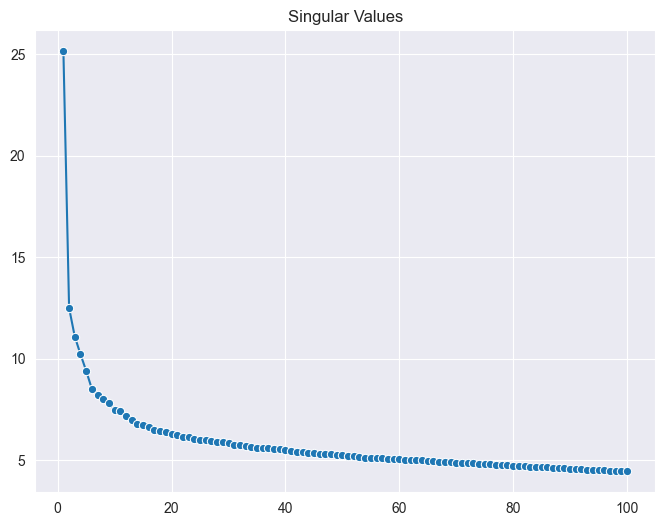

In [26]:
print(Sigma[:10])
plot_singular_values(Sigma)

In [27]:
terms_lsa =  V_T.T @ diag(Sigma)
normalized_terms_lsa = normalize_by_rows(terms_lsa)
documents_lsa = U @ diag(Sigma)
normalized_documents_lsa = normalize_by_rows(documents_lsa)

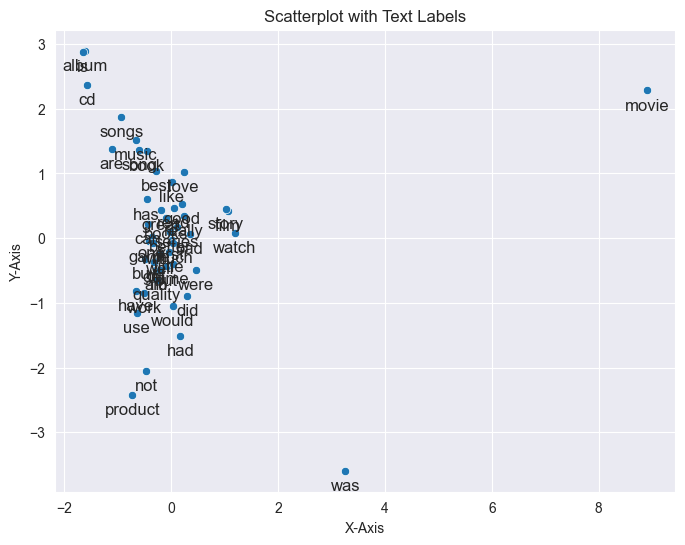

In [28]:
# Create a Seaborn scatterplot
plt.figure(figsize=(8, 6))
threshold = 5
mask = normalized_terms_lsa > threshold
data = terms_lsa[mask, :][:, 2:4]
texts = words[mask]
sns.scatterplot(x=data[:, 0], y=data[:, 1])

# Add text labels under each point
for (x, y), word in zip(data, texts):
    plt.text(x, y - 0.3, word, ha='center', fontsize=12)

# Add labels, title, and adjust plot settings as needed
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Scatterplot with Text Labels')
plt.grid(True)

# Show the plot
plt.show()

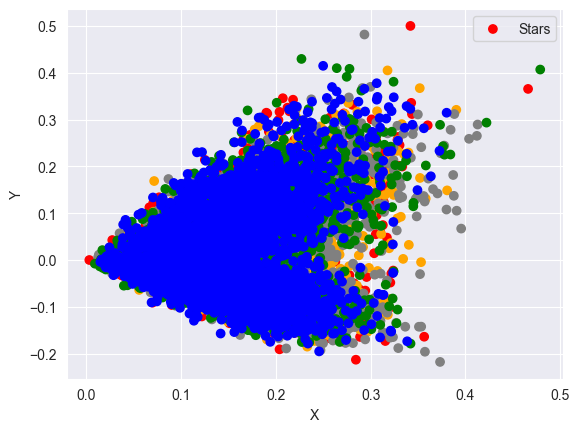

In [29]:
import matplotlib.pyplot as plt

categories = dataset['stars'].values
# Define a color mapping for categories
color_mapping = {
    1: 'red',
    2: 'orange',
    3: 'gray',
    4: 'green',
    5: 'blue'
}
for i in range(1):
    # Create a scatter plot with different colors for each category
    fig, ax = plt.subplots()
    ax.scatter(documents_lsa[:, i], 
               documents_lsa[:, i+1], 
               c=list(map(lambda x: color_mapping[x], categories)),
               label='Stars')
    
    # Add legend
    ax.legend()
    
    # Set labels for x and y axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Show the plot
    plt.show()


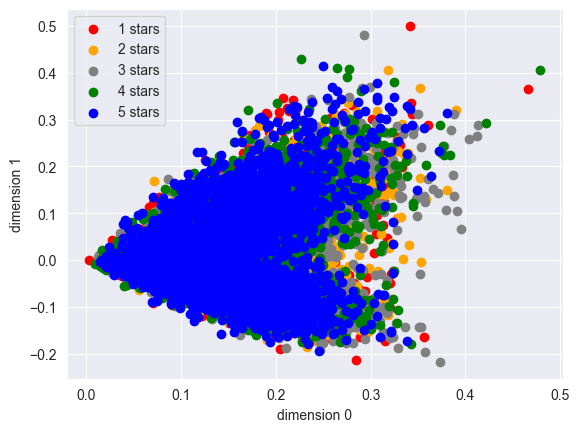

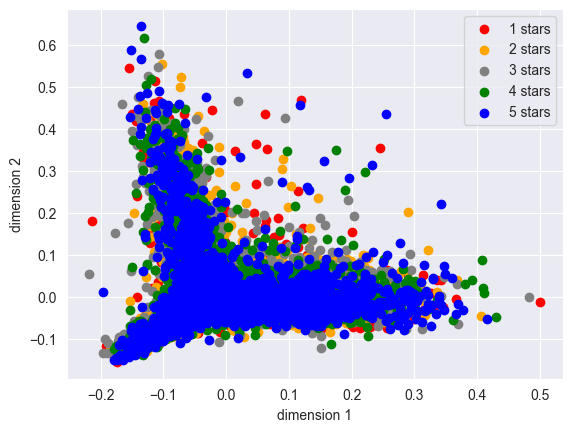

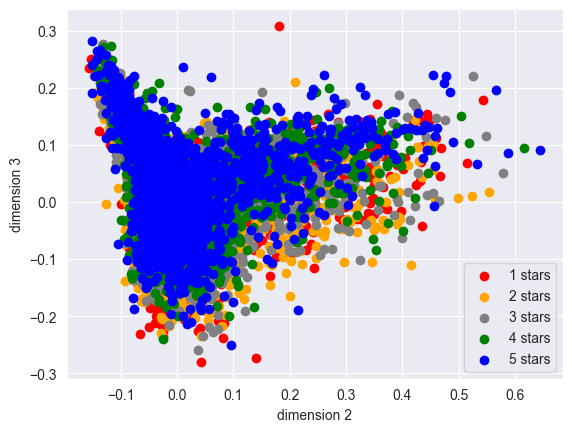

In [30]:
import matplotlib.pyplot as plt

# Assuming 'categories' contains values 1 through 5

# Define a color mapping for categories
color_mapping = {
    1: 'red',
    2: 'orange',
    3: 'gray',
    4: 'green',
    5: 'blue'
}

# Create an empty list to store scatter plot objects for the legend
scatter_plots = []

# Create a scatter plot for each category
for i in range(3):
    fig, ax = plt.subplots()
    for category in range(1, 6):
        category_indices = (categories == category)
        scatter = ax.scatter(documents_lsa[category_indices, i], 
                             documents_lsa[category_indices, i+1], 
                             c=color_mapping[category],
                             label=f'{category} stars')

    # Add legend using scatter plot objects
    ax.legend()

    # Set labels for x and y axes
    ax.set_xlabel(f'dimension {i}')
    ax.set_ylabel(f'dimension {i+1}')

    # Show the plot
    plt.show()


In [31]:
#########################################################################################

In [32]:
X = dataset.text
y = dataset.stars

In [33]:
train_x, test_x, train_y, test_y = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)
print(f'Train size: {len(train_y)}')
print(f'Test size: {len(test_y)}')


Train size: 20000
Test size: 5000


In [34]:
vectorizer = TfidfVectorizer().fit(train_x)
train_features = vectorizer.transform(train_x)
test_features = vectorizer.transform(test_x)

In [35]:
model = SVC()
distributions = {'C': uniform(loc=0, scale=1), 'kernel': ['poly', 'rbf', 'sigmoid']}

In [36]:
clf = RandomizedSearchCV(model, distributions, 
                         scoring='accuracy', 
                         cv=5, 
                         n_iter=3, 
                         # n_jobs=-1,
                         verbose=2)

best_svm_model = clf.fit(train_features, train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..................C=0.8895507662222324, kernel=poly; total time= 2.3min


KeyboardInterrupt: 

In [ ]:
print(f'Best Accuracy Score: {round(best_svm_model.best_score_, 3)}')
print(f'Best Hyperparameters: {best_svm_model.best_params_}')